# Multi-Timescale Prediction
Before we start: This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you want to run the code yourself, you can find the notebook and configuration files [here](https://github.com/neuralhydrology/neuralhydrology/tree/master/examples/04-Multi-Timescale).

This notebook showcases some ways to use the **MTS-LSTM** from our recent publication to generate predictions at multiple timescales: [**"Rainfall-Runoff Prediction at Multiple Timescales with a Single Long Short-Term Memory Network"**](https://hess.copernicus.org/articles/25/2045/2021/).


Let's assume we have a set of daily meteorological forcing variables and a set of hourly variables, and we want to generate daily and hourly discharge predictions.
Now, we could just go and train two separate LSTMs: One on the daily forcings to generate daily predictions, and one on the hourly forcings to generate hourly ones. 
One problem with this approach: It takes a _lot_ of time, even if you run it on a GPU. 
The reason is that the hourly model would crunch through a years' worth of hourly data to predict a single hour (assuming we provide the model input sequences with the same look-back that we usually use with daily data).
That's $365 \times 24 = 8760$ time steps to process for each prediction.
Not only does this take ages to train and evaluate, but also the training procedure becomes quite unstable and it is theoretically really hard for the model to learn dependencies over that many time steps.
What's more, the daily and hourly predictions might end up being inconsistent, because the two models are entirely unrelated.

## Data requirements

To be able to run this example yourself, you will need to download the [hourly NLDAS forcings and the hourly streamflow data](https://doi.org/10.5281/zenodo.4072700) and the [extended Maurer forcings](https://doi.org/10.4211/hs.17c896843cf940339c3c3496d0c1c077). Within the CAMELS US root directory, place the `nldas_hourly` into a folder called `hourly` (`/path/to/CAMELS_US/hourly/nldas_hourly`) and the `maurer_extended` folder into `basin_mean_forcing` (`/path/to/CAMELS_US/basin_mean_forcing/maurer_extended`)

## MTS-LSTM

MTS-LSTM solves these issues: We can use a single model to predict both hourly and daily discharge, and with some tricks, we can push the model toward predictions that are consistent across timescales.

### The Intuition

The basic idea of MTS-LSTM is this: we can process time steps that are far in the past at lower temporal resolution.
As an example, to predict discharge of September 10 9:00am, we'll certainly need fine-grained data for the previous few days or weeks.
We might also need information from several months ago, but we probably _don't_ need to know if it rained at 6:00am or 7:00am on May 15.
It's just so long ago that the fine resolution doesn't matter anymore.

### How it's Implemented

The MTS-LSTM architecture follows this principle: To predict today's daily and hourly dicharge, we start feeding daily meteorological information from up to a year ago into the LSTM.
At some point, say 14 days before today, we split our processing into two branches:
1. The first branch just keeps going with daily inputs until it outputs today's daily prediction.
So far, there's no difference to normal daily-only prediction.
2. The second branch is where it gets interesting: We take the LSTM state from 14 days before today, apply a linear transformation to it, and then use the resulting states as the starting point for another LSTM, which we feed the 14 days of _hourly_ data until it generates today's 24 hourly predictions.

Thus, in a single forward pass through the MTS-LSTM, we've generated both daily and hourly predictions.

If you prefer visualizations, here's what the architecture looks like:

![MTS-LSTM-Visualization.jpg](https://raw.githubusercontent.com/neuralhydrology/neuralhydrology/master/examples/04-Multi-Timescale/mtslstm.jpg)

You can see how the first 362 input steps are done at the daily timescale (the visualization uses 362 days, but in reality this is a tunable hyperparameter).
Starting with day 363, two things happen:
- The _daily_ LSTM just keeps going with daily inputs.
- We take the hidden and cell states from day 362 and pass them through a linear layer. Starting with these new states, the _hourly_ LSTM begins processing hourly inputs.

Finally, we pass the LSTMs' outputs through a linear output layer ($\text{FC}^H$ and $\text{FC}^D$) and get our predictions.

### Some Variations

Now that we have this model, we can think of a few variations:
1. Because the MTS-LSTM has an individual branch for each timescale, we can actually use a different forcings product at each timescale (e.g., daily Daymet and hourly NLDAS). Going even further, we can use _multiple_ sets of forcings at each timescale (e.g., daily Daymet and Maurer, but only hourly NLDAS). This can improve predictions a lot (see  [Kratzert et al., 2020](https://hess.copernicus.org/articles/25/2685/2021/hess-25-2685-2021.html)).
2. We could also use the same LSTM weights in all timescales' branches. We call this model the shared MTS-LSTM (sMTS-LSTM). In our results, the shared version generated slightly better predictions if all we have is one forcings dataset. The drawback is that the model doesn't support per-timescale forcings. Thus, if you have several forcings datasets, you'll most likely get better predictions if you use MTS-LSTM (non-shared) and leverage all your datasets.
3. We can link the daily and hourly predictions during training to nudge the model towards predictions that are consistent across timescales. We do this by means of a regularization of the loss function that increases the loss if the average daily prediction aggregated from hourly predictions does not match the daily prediction.

## Using MTS-LSTM

So, let's look at some code to train and evaluate an MTS-LSTM!
The following code uses the NeuralHydrology package to train an MTS-LSTM on daily and hourly discharge prediction.
For the sake of a quick example, we'll train our model on just a single basin. 
When you actually care about the quality of your predictions, you'll generally get much better model performance when training on hundreds of basins.

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.utils.config import Config

Every experiment in NeuralHydrology uses a configuration file that specifies its setup. The config file for this example is called `1_basin.yml` and can be found in the same directory as this notebook file.
Let's look at some of the relevant configuration options:

In [2]:
run_config = Config(Path("1_basin.yml"))
print('model:\t\t', run_config.model)
print('use_frequencies:', run_config.use_frequencies)
print('seq_length:\t', run_config.seq_length)

model:		 mtslstm
use_frequencies: ['1H', '1D']
seq_length:	 {'1D': 365, '1H': 336}


`model` is obvious: We want to use the MTS-LSTM. For the sMTS-LSTM, we'd set `run_config.shared_mtslstm = True`.
In `use_frequencies`, we specify the timescales we want to predict.
In `seq_length`, we specify for each timescale the look-back window. Here, we'll start with 365 days look-back, and the hourly LSTM branch will get the last 14 days ($336/24 = 14$) at an hourly resolution.

As we're using the MTS-LSTM (and not sMTS-LSTM), we can use different input variables at each frequency.
Here, we use Maurer and Daymet as daily inputs, while the hourly model component uses NLDAS, Maurer, and Daymet.
Note that even though Daymet and Maurer are daily products, we can use them to support the hourly predictions.

In [3]:
print('dynamic_inputs:')
run_config.dynamic_inputs

dynamic_inputs:


{'1D': ['prcp(mm/day)_maurer_extended',
  'srad(W/m2)_maurer_extended',
  'tmax(C)_maurer_extended',
  'tmin(C)_maurer_extended',
  'vp(Pa)_maurer_extended',
  'prcp(mm/day)_daymet',
  'srad(W/m2)_daymet',
  'tmax(C)_daymet',
  'tmin(C)_daymet',
  'vp(Pa)_daymet'],
 '1H': ['convective_fraction_nldas_hourly',
  'longwave_radiation_nldas_hourly',
  'potential_energy_nldas_hourly',
  'potential_evaporation_nldas_hourly',
  'pressure_nldas_hourly',
  'shortwave_radiation_nldas_hourly',
  'specific_humidity_nldas_hourly',
  'temperature_nldas_hourly',
  'total_precipitation_nldas_hourly',
  'wind_u_nldas_hourly',
  'wind_v_nldas_hourly',
  'prcp(mm/day)_maurer_extended',
  'srad(W/m2)_maurer_extended',
  'tmax(C)_maurer_extended',
  'tmin(C)_maurer_extended',
  'vp(Pa)_maurer_extended',
  'prcp(mm/day)_daymet',
  'srad(W/m2)_daymet',
  'tmax(C)_daymet',
  'tmin(C)_daymet',
  'vp(Pa)_daymet']}

## Training

We start model training of our single-basin toy example with `start_run`.

**Note** The config file assumes that the CAMELS US dataset is stored under `data/CAMELS_US` (relative to the main directory of this repository) or a symbolic link exists at this location. Make sure that this folder contains the required subdirectories `basin_mean_forcing`, `usgs_streamflow`, `hourly` and `camels_attributes_v2.0`. If your data is stored at a different location and you can't or don't want to create a symbolic link, you will need to change the `data_dir` argument in the `1_basin.yml` config file that is located in the same directory as this notebook.

In [4]:
start_run(config_file=Path("1_basin.yml"))

2022-01-05 22:02:00,435: Logging to /home/frederik/Projects/neuralhydrology/examples/04-Multi-Timescale/runs/test_run_0501_220200/output.log initialized.
2022-01-05 22:02:00,436: ### Folder structure created at /home/frederik/Projects/neuralhydrology/examples/04-Multi-Timescale/runs/test_run_0501_220200
2022-01-05 22:02:00,436: ### Run configurations for test_run
2022-01-05 22:02:00,436: experiment_name: test_run
2022-01-05 22:02:00,436: use_frequencies: ['1H', '1D']
2022-01-05 22:02:00,437: train_basin_file: 1_basin.txt
2022-01-05 22:02:00,437: validation_basin_file: 1_basin.txt
2022-01-05 22:02:00,437: test_basin_file: 1_basin.txt
2022-01-05 22:02:00,437: train_start_date: 1999-10-01 00:00:00
2022-01-05 22:02:00,437: train_end_date: 2008-09-30 00:00:00
2022-01-05 22:02:00,438: validation_start_date: 1996-10-01 00:00:00
2022-01-05 22:02:00,438: validation_end_date: 1999-09-30 00:00:00
2022-01-05 22:02:00,438: test_start_date: 1989-10-01 00:00:00
2022-01-05 22:02:00,439: test_end_date:

## Evaluation

Given the trained model, we can generate and evaluate its predictions. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name.

In [5]:
run_dir = Path("runs/test_run_0501_220200")  # you'll find this path in the output of the training above.

# create a tester instance and start evaluation
tester = get_tester(cfg=Config(run_dir / "config.yml"), run_dir=run_dir, period="test", init_model=True)
results = tester.evaluate(save_results=False, metrics=run_config.metrics)

results.keys()

2022-01-05 22:07:30,580: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2022-01-05 22:07:30,595: Using the model weights from runs/test_run_0501_220200/model_epoch050.pt
# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


dict_keys(['01022500'])

Let's take a closer look at the predictions and do some plots, starting with the daily results.
Note that units are mm/h even for daily values, since we predict daily averages.

Daily metrics:
  NSE: 0.798
  MSE: 0.002
  RMSE: 0.048
  KGE: 0.770
  Alpha-NSE: 0.793
  Beta-NSE: -0.002
  Pearson-r: 0.900
  FHV: -22.331
  FMS: -19.091
  FLV: 58.134
  Peak-Timing: 0.625


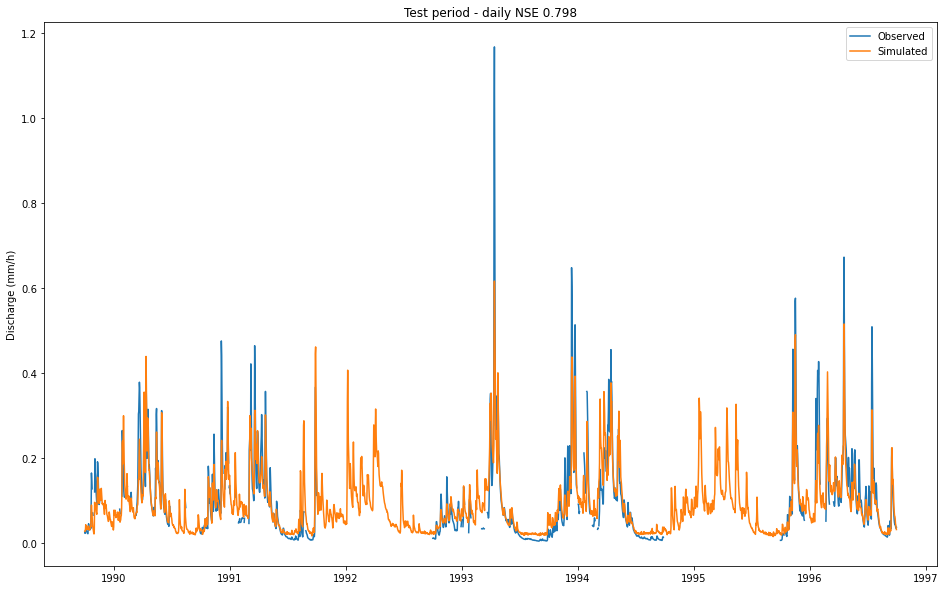

In [6]:
# extract observations and simulations
daily_qobs = results["01022500"]["1D"]["xr"]["qobs_mm_per_hour_obs"]
daily_qsim = results["01022500"]["1D"]["xr"]["qobs_mm_per_hour_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(daily_qobs["date"], daily_qobs, label="Observed")
ax.plot(daily_qsim["date"], daily_qsim, label="Simulated")
ax.legend()
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - daily NSE {results['01022500']['1D']['NSE_1D']:.3f}")

# Calculate some metrics
values = metrics.calculate_all_metrics(daily_qobs.isel(time_step=-1), daily_qsim.isel(time_step=-1))
print("Daily metrics:")
for key, val in values.items():
    print(f"  {key}: {val:.3f}")

...and finally, let's look more closely at the last few months' hourly predictions:

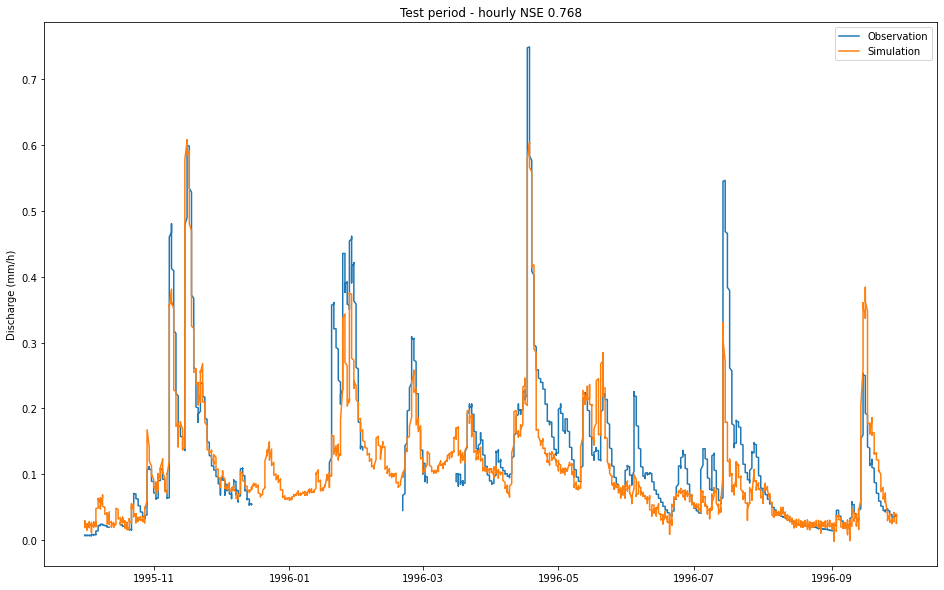

In [7]:
# extract a date slice of observations and simulations
hourly_xr = results["01022500"]["1H"]["xr"].sel(date=slice("10-1995", None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select all 24 hours of each day and then stack
# the two dimensions into one consecutive datetime dimension.
hourly_xr = hourly_xr.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
hourly_xr['datetime'] = hourly_xr.coords['date'] + hourly_xr.coords['time_step']

hourly_qobs = hourly_xr["qobs_mm_per_hour_obs"]
hourly_qsim = hourly_xr["qobs_mm_per_hour_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(hourly_qobs["datetime"], hourly_qobs, label="Observation")
ax.plot(hourly_qsim["datetime"], hourly_qsim, label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['01022500']['1H']['NSE_1H']:.3f}")
_ = ax.legend()